# Tutorial - Reinforcement Learning - CartPole

In this tutorial, we will build a Deep Q-Network to balance a pole on a cart

Note that this notebook is unstable. Sometimes the network learns, sometimes, it doesn't. Don't be surprised if it doesn't learn anything...

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
#assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')




# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [4]:
import gym

Let's list all the available environments:

In [5]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v2), EnvSpec(BipedalWalkerHardcore-v2), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [6]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [7]:
env.seed(42)
obs = env.reset()

Observations vary depending on the environment. In this case it is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

In [8]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment).

**Warning**: some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify `mode="rgb_array"`. In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like [Xvfb](http://en.wikipedia.org/wiki/Xvfb). On Debian or Ubuntu:

```bash
$ apt update
$ apt install -y xvfb
```

You can then start Jupyter using the `xvfb-run` command:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Alternatively, you can install the [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) Python library which wraps Xvfb:

```bash
python3 -m pip install -U pyvirtualdisplay
```

And run the following code:

In [9]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [10]:
env.render()

True

In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [11]:
img = env.render(mode="rgb_array")
img.shape

(800, 1200, 3)

In [12]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

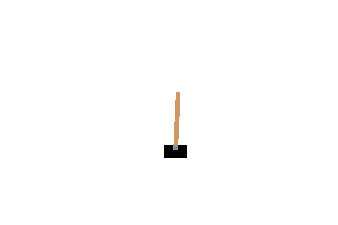

In [13]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [14]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right.

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [15]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

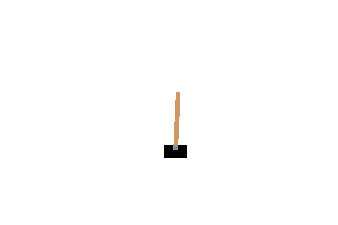

In [16]:
plot_environment(env)


Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [17]:
reward

1.0

When the game is over, the environment returns `done=True`:

In [18]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [19]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue to use it.

In [20]:
if done:
    obs = env.reset()

# Deep Q-Network

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [21]:
#tf.random.set_seed(42)
#np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="elu", input_shape=input_shape),
    keras.layers.Dense(10, activation="elu"),
    keras.layers.Dense(n_outputs)
])

Instructions for updating:
Colocations handled automatically by placer.


To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [22]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

We will also need a replay memory. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that:

In [23]:
from collections import deque

replay_memory = deque(maxlen=2000)

And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: `[obs, actions, rewards, next_obs, dones]`.

In [24]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [25]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

In [26]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * max_next_Q_values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

And now, let's train the model!

In [27]:
#env.seed(42)
#np.random.seed(42)


rewards = [] 
best_score = 0

In [32]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step > best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 100:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 101, Steps: 15, eps: 0.798

TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type float64 of argument 'a'.

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)

plt.show()

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
#env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

Not bad at all!

In [ ]:
env.close()